# Z3 : un problème ? Pas de problème !

In [1]:
from z3 import *  # yeah maaaan

## Avant-propos

z3 est un **solveur de contraintes** créé par Microsoft Research. En des termes plus techniques, c'est un  *Satisfiability Modulo Theories solver* (SMT solver).

Ce que ça veut dire, c'est que vous allez lui donner des **contraintes** : une équation avec une inconnue par exemple. Il va transformer cette contrainte en une suite de variables booléennes puis va évaluer la cohérente du modèle. Une fois que le modèle est reconnu possible, il essaye de le satisfaire, en trouvant les inconnues de notre équation.

On va apprendre à utiliser z3 pour résoudre des problèmes de logique simples et plus avancés comme les  **nqueens** ou encore pour son usage en CTF sur un challenge de **crackme**.

# Le lycéen fainéant

Un lycéen qui n'en peut plus des Maths mais qui a des notions de Python décide de scripter la résolution de son exercice.

L'énoncé est le suivant :
"*Trouver des valeurs de a, b et c validant l'expression a + 2b + 3c = a + c tels que a != b != c a,b,c étant entiers*"

Le lycéen commence donc par **définir ses variables** avec z3

In [2]:
a = Int('a')  # définit une variable entière de valeur inconnue qui sera nommée comme 'a'
b = Int('b')
c = Int('c')

solver = Solver()  # déclare une instance du solveur de contraintes

Il explicite ensuite les **contraintes** de l'exercice

In [3]:
# a != b != c
solver.add(Distinct(a, b, c))
solver.add(a + 2 * b + 3 * c == a + c)

Il résout son exercice

In [4]:
solver.check()

sat

*sat* signifie que les contraintes ont été satisfaites, autrement dit que le solveur a trouvé des solutions aux contraintes !

In [5]:
solver.model()

[b = -1, a = -2, c = 1]

```-2 != -1 != 1```
et
```-2 + -1 * 3 + 1 * 3 = -2 + 1```
<=>
```-2 = -2```
l'exercice est résolu !

*Note: pour débugguer vos contraintes, vous pouvez afficher votre solveur !*

In [6]:
print(solver)

[Distinct(a, b, c), a + 2*b + 3*c == a + c]


*Note2: On aurait aussi pu commencer par simplifier l'expressions avec simplify() !*

In [7]:
simplify(a + 2 * b + 3 * c == a + c)

2*b + 2*c == 0

# Petit challenge de logique

Ok maintenant le lycéen va jouer à Minecraft. Il va sur un serveur de mini-jeux et joue à un jeu de redstone. 
Pour ceux qui ne voient pas du tout ce qu'est la redstone, imaginez un circuit composé d'**entrées** : les leviers (ON => 1, OFF => 0) et de **portes logiques** (AND, OR, XOR).

Il a devant lui le circuit que l'on peut schématiser comme suit :

```
Levier 1 ===========
                   |= AND =
Levier 2 ===========      |= XOR =====
                          |          |
Levier 3 ==================          |== AND==>>
                                     |
Levier 4 =============================

"=" et "|" représentent le circuit
">>" représente la sortie
```

Le but du challenge, c'est d'activer les bons leviers pour qu'en sortie, on obtienne 1.
Ayant un terrible enthousiasme pour z3, il décide d'utiliser ce framework pour résoudre l'épreuve au lieu de réfléchir 1 sec.

In [8]:
# on définit les leviers (sachant que True == 1 == levier activé)
lev1 = Bool('lev1')
lev2 = Bool('lev2')
lev3 = Bool('lev3')
lev4 = Bool('lev4')

# on instancie notre solveur
solver = Solver()

In [9]:
# on définit la logique de notre circuit
op1 = And(lev1, lev2)
op2 = Xor(op1, lev3)
op3 = And(op2, lev4)

solver.add(op3)
# Remarque : solver.add(op3) == solver.add(op3 == True)

In [10]:
# pour info
print(solver)
print()
print(simplify(op3))

[And(Xor(And(lev1, lev2), lev3), lev4)]

And(Not(And(lev1, lev2)) == lev3, lev4)


In [18]:
if solver.check() == sat:
    print(solver.model())

[lev1 = False, lev2 = False, lev3 = True, lev4 = True]


Une solution à ce problème est donc
```
    OFF  ==========
                   |= AND =
    OFF  ==========       |= XOR =====
                          |          |
     ON  ==================          |== AND==>> 1
                                     |
     ON  =============================
```
Si vous voulez voir quelque chose dans le même genre mais bien plus avancé :
[![LiveOverflowZ3](https://img.youtube.com/vi/nI8Q1bqT8QU/0.jpg)](https://youtu.be/nI8Q1bqT8QU)

# Les choses sérieuses

Bon maintenant on arrête l'histoire du lycéen et on se concentre sur de **vrais problèmes**.

### Le problèmes des nqueens

L'exercice des nqueens est un peu le hello world de l'algorithmie. Le but est très simple : on prend un échiquier  de n x n cases et le but est d'y placer n reines sans qu'elles puissent s'attaquer. Pour rappel une reine peut attaquer sur toute une ligne, colonne ou diagonale.

Pour résoudre ce problème, on réalise normalement un algorithme de backtracking. Ici pas besoin : avec z3 on exprime juste notre problème sous forme de contraintes !

On part donc du constat qu'il est impossible d'avoir deux reines sur la même ligne.

In [12]:
from itertools import product
from re import findall
import chess, chess.svg


######################################################################
#       JUSTE DU DISPLAY, PAS TRÈS IMPORTANT, PASSEZ CE BLOC         #
######################################################################
def print_nqueens(res: list) -> None:
    """ prints nqueens chessboard
    """
    n = len(res)
    print(f"nqueens-z3 result for n={n}")
    pos = []
    order = []
    for i in range(n):
        order.append(findall("\d+", str(res[i]))[0])
    for i in range(n):
        index = order.index(str(i))
        pos.append(res[res[index]])
    res = ""
    if n != 8:
        for i, j in product(range(n), range(n)):
            if pos[i] == j:
                res += f" {chr(0x25A0)}"
            else:
                res += f" {chr(0x25A1)}"
            if j == n - 1 and i != n - 1:
                res += "\n"
        print(res)
        print()
    else:
        board = ""
        for line in range(n):
            index = pos.index(line)
            column = int(order[index])
            board += str(column) if column else ""
            board += "q"
            board += str(n-column-1) if n-column-1 else ""
            if line != n-1:
                board += "/"
        board = chess.Board(board)
        return chess.svg.board(board=board)


On peut résumer le challenge des nqueens en contraintes:
*  Toutes les reines sont placées sur le plateau de taille n * n
*  On doit placer n reines sur le plateau
*  Il ne peut y avoir zéro ou une seule reine sur chaque ligne, colonne, diagonale

In [13]:
def solve_nqueens(n: int) -> bool:
    """ solves nqueen problem
    
    :n size of the board and number of queens to place on it
    :returns solutions if model is sat
    """
    solver = Solver()
    # on définit notre tableau colonne qui va représenter
    # les différentes positions de nos n reines
    columns = [Int(f"col{i}") for i in range(n)]
    # on set nos éléments sur le jeu
    for i in range(n):
        solver.add(And(columns[i] >= 0, columns[i] < n))
    # chaque reine doit être unique sur sa ligne
    solver.add(Distinct(columns))
    # on indique qu'une seule reine peut se trouver sur chaque colonne
    for i in range(n-1):
        for j in range(i+1, n):
            solver.add((columns[i] - columns[j])**2 != (i - j)**2)
    if solver.check() == sat:
        return solver.model()

nqueens-z3 result for n=4
 □ □ ■ □
 ■ □ □ □
 □ □ □ ■
 □ ■ □ □

nqueens-z3 result for n=10
 □ □ □ □ □ □ □ □ ■ □
 □ ■ □ □ □ □ □ □ □ □
 □ □ □ □ ■ □ □ □ □ □
 □ □ □ □ □ □ □ ■ □ □
 ■ □ □ □ □ □ □ □ □ □
 □ □ □ □ □ □ ■ □ □ □
 □ □ □ □ □ □ □ □ □ ■
 □ □ ■ □ □ □ □ □ □ □
 □ □ □ □ □ ■ □ □ □ □
 □ □ □ ■ □ □ □ □ □ □

nqueens-z3 result for n=8


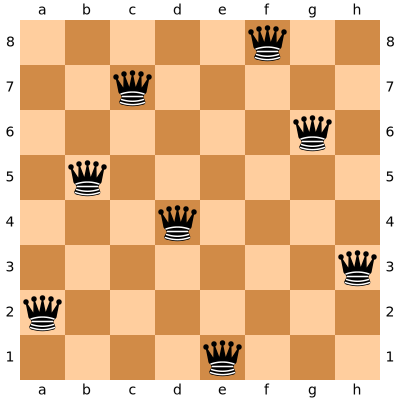

In [14]:
res = solve_nqueens(4)
print_nqueens(res)

res = solve_nqueens(10)
print_nqueens(res)

res = solve_nqueens(8)
print_nqueens(res)

## Crackme

Vous êtes en CTF. Il reste plus que 5 min et vous tombez sur ce crackme :

In [15]:
def crackme(flag: str) -> str:
    if len(flag) != 8 or flag[-1] != "G":
        return "Nope"
    x = [491, 1013, 51, 48, 6, 72, 72, 159, 315, 554, 865, 1246, 1942, 412, 113, 129, 143, 167, 321, 23, 64, 123, 34, 34]
    c = [ord(i) for i in flag]
    j = int(len(x) * 2 / len(flag))
    for i in range(len(c)):
        if sum(c[:i]) != x[j] - x[j-1]:
            return "Nope"
        j = int((j + 1) % (len(x) / 2))
    print("GGWP")

Pas de problème ! En 5 min vous avez largement le temps de faire votre solveur avec z3 !

In [16]:
######################################################################
#       JUSTE DU DISPLAY, PAS TRÈS IMPORTANT, PASSEZ CE BLOC         #
######################################################################
def print_crackme_res(m):
    order = []
    for i in range(len(m)):
        order.append(findall("\d+", str(m[i]))[0])
    string = ""
    for i in range(len(m)):
        string += chr(m[m[order.index(str(i))]].as_long())
    print(f"flag: {string}")

In [17]:
def solve_crackme() -> str:
    solver = Solver()
    # on définit notre flag
    flag = [Int(f"s{i}") for i in range(8)]
    # on définit les variables du crackme
    x = [491, 1013, 51, 48, 6, 72, 72, 159, 315, 554, 865, 1246, 1942, 412, 113, 129, 143, 167, 321, 23, 64, 123, 34, 34]
    j = int(len(x) * 2 / len(flag))
    # on indique à z3 que nos caractères sont des caractères ASCII
    for c in flag:
        solver.add(And(c < 255, c >= 32))
    # on ajoute la contrainte sur la dernière lettre
    solver.add(flag[-1] == ord("G"))
    # on définit la routine du crackme
    for i in range(8):
        solver.add(sum(flag[:i]) == x[j] - x[j - 1])
        j = int((j + 1) % (len(x) / 2))
    # on part boire une pinte
    if solver.check() == sat:
        return solver.model()
       

res = solve_crackme()
if res:
    print_crackme_res(res)

flag: WESHFLAG
